In [2]:
import os
import glob
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import simple_norm

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Circle

from pathlib import Path


from astropy.convolution import Gaussian2DKernel as g2
from astropy.convolution import Box2DKernel as b2
from astropy.convolution import convolve

# this is a package for photometric analysis. It is not used in this code, but it is quit useful: 
# from photutils import CircularAperture,aperture_photometry,CircularAnnulus

In [9]:
# define the directory of flat images and dark images
flt_dir = 'data/SDSSJ000430.33-101129.6/F150/'
drk_dir = 'dark_ref/'

targets = glob.glob(flt_dir+'*flt.fits')  # the files we will be reducing


# make directories for the prodcut files, analysis plots 
# the directories will locate in the flat images directory. 
product_dir = flt_dir + 'product/'
plot_dir = product_dir + 'plot/'

Path(product_dir).mkdir(parents=True, exist_ok=True)
Path(plot_dir).mkdir(parents=True, exist_ok=True)

In [10]:
# general parameters 

# when below temp_cutoff, dark current can be neglected, perform sky_subtraction only
temp_cutoff = 22

# Aperture size of the galaxy for each filter.  Here I use 150 pixel for both filter
rf = 130
sky_apt_size = 150

In [11]:
# this function pull out the information from the header.  Doesn't have to be a class honestly.
# the only information we need for dark images are temperature and exposure time.

class prepare:
    
    def __init__(self, filename):
        file = fits.open(filename)
        
        # taking the parameters we need in the header: 
        # rootname, exposure time, temperature, filter, target coordinate 
        self.name = file[0].header['ROOTNAME']
        self.galname = file[0].header['TARGNAME']
        self.expt = file[0].header['EXPTIME']
        self.filter = file[0].header['FILTER1']
        self.RA = file[0].header['RA_TARG']
        self.DEC = file[0].header['DEC_TARG']
        self.temp = 0.5*(file[1].header['MDECODT1'] + file[1].header['MDECODT2'])
        
        # convert target coordinate (RA, DEC) into (pix_x, pix_y)
        w = WCS(file[('sci',1)].header, file)
        self.w_x, self.w_y=w.all_world2pix(file[0].header['RA_TARG'],file[0].header['DEC_TARG'],1, maxiter=50)
        
        file.close()
        
        # since np.nan-np.nan !=0 (happens on dark image, since there is no w_x)
        if self.w_x-self.w_x ==0 :   
            self.r_f = rf
            self.r_lim= int(min(1012-self.w_x, self.w_x-12, 1012-self.w_y, self.w_y-12))
        else:
            self.r_f=150
            self.r_lim= 350
          
        # new_name is the name of the product file
        self.new_name = self.name + '_fd.fits'
        self.path = product_dir + self.new_name
 

In [12]:
# We will make the annulus of science image here 
# In this class we can get: annulus mask, images, data quality maps

class mask_image: 
    def __init__(self, filename):
        self.filename=filename
        image = fits.getdata(filename)
        DQ = fits.getdata(filename, 3)  #Data Quality
        self.DQ = DQ
        # mask out the bad pixels as np.nan
        image_gp=image*0     # create an np.ndarray that has the same shape as "image", and work on this array
        image_gp[:,:]=image
        image_gp[DQ!=0]= np.nan # gp stands for good pixels. Only good pixels will return values
        
        
        self.image = image_gp
        self.nx, self.ny = np.shape(self.image)
        self.cent_x = prepare(filename).w_x
        self.cent_y = prepare(filename).w_y
        
    # this function return the annulus between r_in and r_out.  
    # If you need a circle, set r_in = 0
    def annulus(self, r_in, r_out): 
        y, x = np.mgrid[0:self.ny, 0:self.nx]
        cent_x = self.cent_x
        cent_y = self.cent_y
        
        if cent_x-cent_x !=0:
            cent_x, cent_y = 512, 512
            # this happens when you are looking at dark images. 
            # In this code, the annulus always come from the science image. 
            
        mask_annulus = [np.where(((x-cent_x)**2 + (y-cent_y)**2 >= r_in**2) \
                               & ((x-cent_x)**2 + (y-cent_y)**2 <= r_out**2)) ]
        
        return mask_annulus[0]
    
    # this function return the image with pixel[DQ!=0] = 0
    def image_DQ0(self):
        image = fits.getdata(self.filename)  
        image_gp=image*0     
        image_gp[:,:]=image
        image_gp[self.DQ!=0]= 0
        return image_gp
    
    # this function return the image with nothing about DQ
    def image_noDQ(self):
        image = fits.getdata(self.filename)  
        return image

In [13]:
# function of sky subtraction, return the sky background 
def sky_value(filename): 
    r_f = prepare(filename).r_f
    sci = mask_image(filename)
    
    apt_size = sky_apt_size 
    
    sci_annulus = [sci.annulus(r_in =r_f+i, r_out=r_f+1+i)  for i in range(apt_size) ]
    m = [np.nanmean([sci.image[sci_annulus[i]]])  for i in range(apt_size)]
    
    sky_value = np.nanmedian(m)
    return sky_value



# function of dark current subtraction, return scale factors and a 2D array of residues
def dark_subtraction(filename): 
    # the parameter space of the dark current , A for the dark current scale, k for sky background
    A = np.arange(0, 2, 0.1)
    K = np.arange(0, 0.02, 1e-3)
    a_best, k_best, ind = 0, 0, 0  # a_best * drks[ind] + k_best   will minimize the background
    residue2d = np.zeros((len(K),len(A)))
    
    sci = prepare(filename)
    
    sci_image = mask_image(filename).image_noDQ()
    sci_DQ = mask_image(filename).DQ
    
    apt_size = sci.r_lim-sci.r_f
    sci_annulus = [mask_image(filename).annulus(r_in =sci.r_f+i, r_out=sci.r_f+1+i)  for i in range(apt_size) ]
   
    

    residue_min=np.sum(sci_image**2)  
    
    drks = glob.glob(drk_dir+'*.fits') # the dark flat images
    drk_DQ=mask_image(drks[0]).DQ      # DQ map for all dark images are the same.
    DQ = sci_DQ+drk_DQ
    for i in range(len(drks)):
        print('working on %s th dark image'%(i+1))
        drk = prepare(drks[i])
        drk_image = mask_image(drks[i]).image_noDQ()
        
        drk_image[DQ != 0] = np.nan
        m_drk = np.array([np.nanmean([drk_image[sci_annulus[i]]])  for i in range(apt_size)])
        
        sci_image[DQ != 0 ] = np.nan
        m_sci = np.array([np.nanmean([sci_image[sci_annulus[i]]])  for i in range(apt_size)])
                
        residue = np.array([ [np.sum((m_sci - a*m_drk*sci.expt/drk.expt - k)**2)  for a in A] for k in K ])

        if np.min(residue.ravel()) < residue_min:
            residue_min = np.min(residue.ravel())
            
            best=np.where(residue==residue_min)
            ind, a_best, k_best = i, best[1], best[0]
            
            print('the best match dark images so far has temp = ',drk.temp)
            print('a, k = ',A[a_best]*sci.expt/drk.expt, K[k_best])
            
    if (len(K)-k_best <= 1) or  (len(A)-a_best <= 1): 
        print('Warning!!!  Scalars on the edge of the parameter sapce.')
        print('You may want to change the parameter limits and run again.')
    return ind, A[a_best]*sci.expt/drk.expt, K[k_best]
    

In [14]:
#  Here I will design the pipeline of dark current subtraction: 
def main(filename): 
    flt = prepare(filename)
    new_filename = flt.new_name
    print('########## begin subtraction for "%s" ###########'%flt.name)
    print('The science image has temp =',flt.temp)
    
    
    hdu = fits.open(filename)
    DQ = fits.getdata(filename, 3)
    
    # if flt.temp < temp_cutoff ,  perform sky subtraction only 
    if flt.temp < temp_cutoff:
        print(flt.name, ' temperature < %s, perform sky subtraction only'%temp_cutoff)
        
        sky = sky_value(filename)
        print('sky background = ', sky)
        hdu[1].data[DQ == 0] = hdu[1].data[DQ == 0] - sky
    
    # if flt.temp > temp_cutoff , perform sky+dark current subtraction 
    else:
        print('temperature > %s, perform sky+dark current subtraction'%temp_cutoff)
        drks = glob.glob(drk_dir+'*.fits')
        
        ind, a, sky = dark_subtraction(filename)
        
        d_hdu = mask_image(drks[ind])
        d_image = d_hdu.image_DQ0()    
        
        hdu[1].data[DQ == 0] = hdu[1].data[DQ == 0] - a * d_image[DQ == 0] - sky
    
    # save file 
    path = flt.path 
    hdu.writeto(path, overwrite=True, output_verify="ignore")
    
    print('science image " %s " complete '%flt.name)
    #####################



In [78]:
for i in range(len(targets)):
    filename = targets[i]
    
    main(filename)

########## begin subtraction for "jdxv42nyq" ###########
The science image has temp = 26.3616
temperature > 22, perform sky+dark current subtraction
working on 1 th dark image
the best match dark images so far has temp =  19.7682
a, k =  [0.0778] [0.014]
working on 2 th dark image
the best match dark images so far has temp =  29.0478
a, k =  [0.0778] [0.006]
working on 3 th dark image
working on 4 th dark image
working on 5 th dark image
working on 6 th dark image
working on 7 th dark image
working on 8 th dark image
working on 9 th dark image
working on 10 th dark image
working on 11 th dark image
working on 12 th dark image
working on 13 th dark image
working on 14 th dark image
working on 15 th dark image
working on 16 th dark image
working on 17 th dark image
working on 18 th dark image
working on 19 th dark image
working on 20 th dark image
science image " jdxv42nyq " complete 
########## begin subtraction for "jdxv42ntq" ###########
The science image has temp = 21.1113
jdxv42ntq 

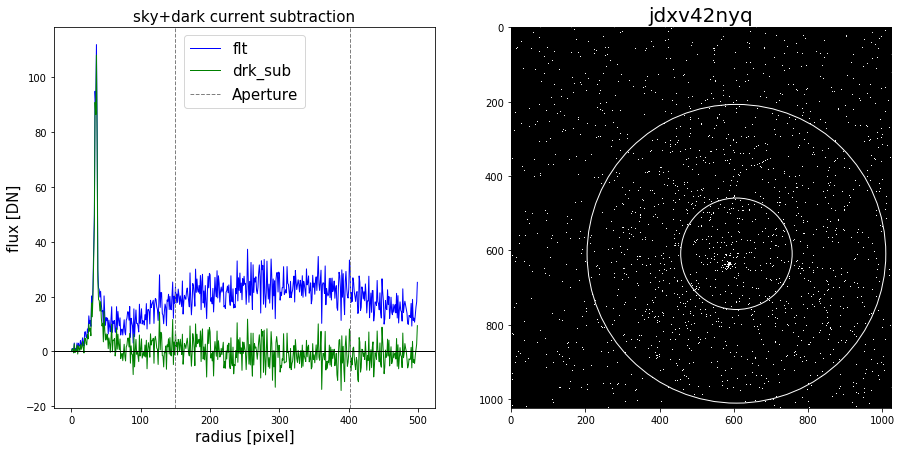

##################################


KeyboardInterrupt: 

In [40]:
# make plots
for i in range(len(targets)):
    file = targets[i]
    flt = prepare(file)
    name = flt.name
    fd_file = prepare(file).path

    
    
    image = fits.getdata(fd_file)
    sci = mask_image(file)
    fd = mask_image(fd_file)

    apt_size = 500
    sci_annulus = [sci.annulus(r_in =0+i, r_out=1+i)  for i in range(apt_size) ]
    s_flt = [np.nansum([sci.image[sci_annulus[i]]])  for i in range(apt_size)]
    s_fd = [np.nansum([fd.image[sci_annulus[i]]])  for i in range(apt_size)]
    
    norm1=simple_norm(image, 'linear',min_cut=0.1, max_cut=1)
    
    
    if flt.temp < temp_cutoff:
        ax0_title = 'sky subtraction'
        r_out = flt.r_f+100
    else: 
        ax0_title = 'sky+dark current subtraction'
        r_out = flt.r_lim
    circle1 = plt.Circle((flt.w_x, flt.w_y), flt.r_f, color='w', fill=False)
    circle2 = plt.Circle((flt.w_x, flt.w_y), r_out, color='w', fill=False)
    
    
    
    ####### plot #######
    fig, ax = plt.subplots(1,2,figsize=(15, 7))
    ax = ax.ravel()
    
    x=np.arange(apt_size)
    ax[0].set_title(ax0_title, fontsize=15)
    ax[0].plot(x,s_flt, color='b', lw=1,label='flt')
    ax[0].plot(x,s_fd, color='g', lw=1,label='drk_sub')
    ax[0].axhline(0, color='k', lw=1)
    ax[0].axvline(x=r_out,linestyle='--', color='gray', lw=1)
    ax[0].axvline(x=flt.r_f,linestyle='--', color='gray', lw=1, label='Aperture')
    ax[0].set_xlabel('radius [pixel]', fontsize=15)
    ax[0].set_ylabel('flux [DN]', fontsize=15)
    ax[0].legend(fontsize=15)

     
    ax[1].set_title(name, fontsize=20)
    ax[1].imshow(image, cmap='gray', norm=norm1)
    ax[1].add_artist(circle1)
    ax[1].add_artist(circle2)
    
    
    
    

    plt.show()
    path = plot_dir+name
    fig.savefig(path, dpi=100)
    print('##################################')
        
    

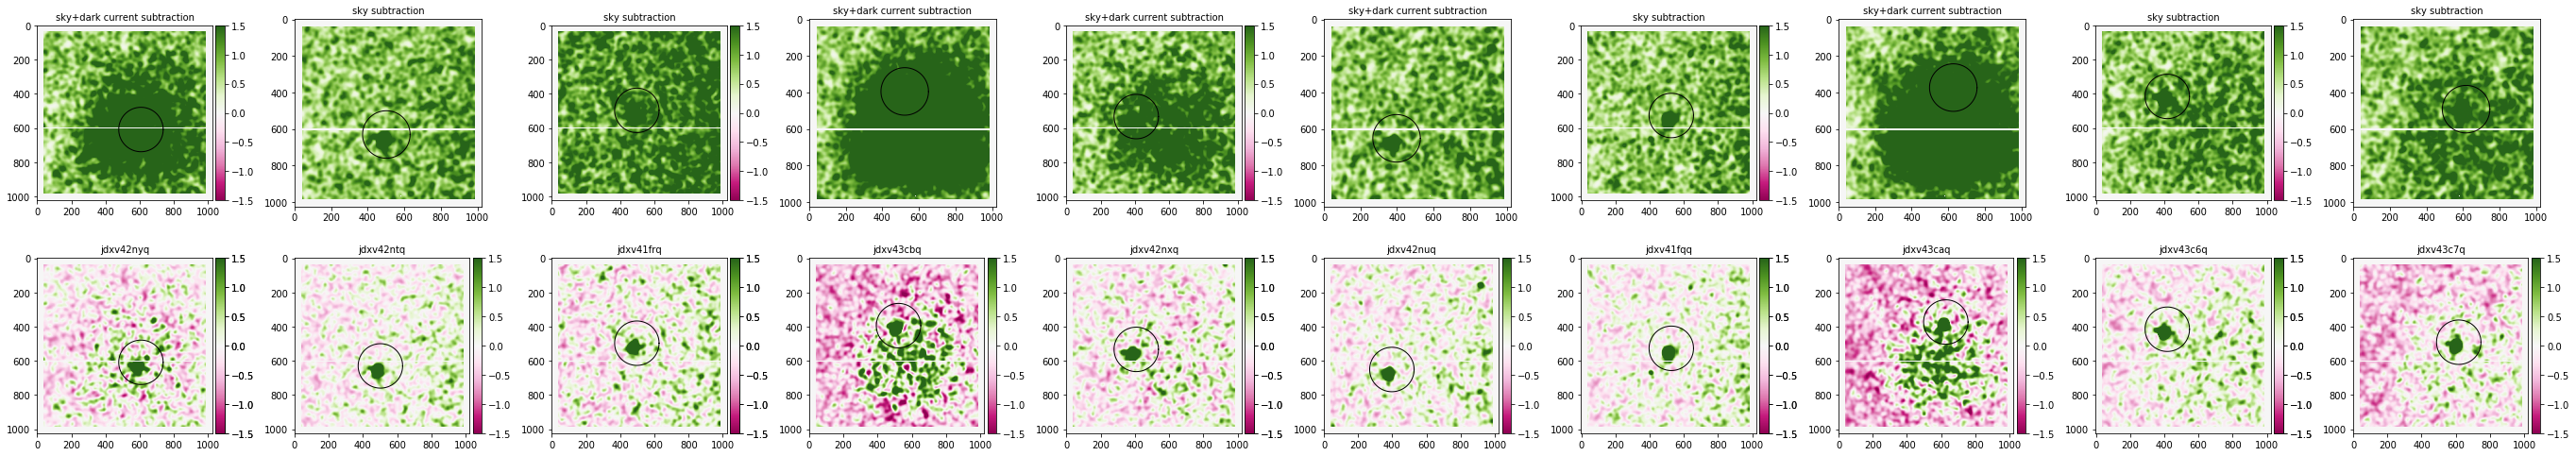

In [81]:
# make plots
fig, ax = plt.subplots(2,len(targets),figsize=(38, 7))
ax = ax.ravel()
for i in range(len(targets)):
    file = targets[i]
    flt = prepare(file)
    name = flt.name
    fd_file = prepare(file).path

    t = flt.expt
    image0 = fits.getdata(file)/t*1e5
    image1 = fits.getdata(fd_file)/t*1e5
    DQ = fits.getdata(file, 3)
    

    
    norm1=simple_norm(image, 'linear',min_cut=-1.5, max_cut=1.5)
    
    
    if flt.temp < temp_cutoff:
        ax0_title = 'sky subtraction'
        r_out = flt.r_f+100
    else: 
        ax0_title = 'sky+dark current subtraction'
        r_out = flt.r_lim
        
        
    theta = np.linspace(0, 2*np.pi, 100)

    r = flt.r_f

    cx = r*np.cos(theta) + flt.w_x
    cy = r*np.sin(theta) + flt.w_y
    

    
    
    
    ####### plot #######
    
    
    
    ax[i].set_title(ax0_title, fontsize=10)
    kernel = g2(10)
    image0[DQ!=0] = 0
    image0 =  convolve(image0, kernel, boundary=None)
    image0[DQ!=0] = 0
    im = ax[i].imshow(image0, cmap='PiYG', norm=norm1)
    ax[i].plot(cx, cy, color='k', lw = 1)

    divider = make_axes_locatable(ax[2*i])
    cax = divider.append_axes("right", size="5%", pad=0.05)

    plt.colorbar(im, cax=cax)
    

     
    ax[i + len(targets)].set_title(name, fontsize=10)
    kernel = g2(10)
    image1[DQ!=0] = 0
    image1 =  convolve(image1, kernel, boundary=None)
    image1[DQ!=0] = 0
    im = ax[i + len(targets)].imshow(image1, cmap='PiYG', norm=norm1)
    ax[i + len(targets)].plot(cx, cy, color='k', lw = 1)
    divider = make_axes_locatable(ax[i + len(targets)])
    cax = divider.append_axes("right", size="5%", pad=0.05)

    plt.colorbar(im, cax=cax)
    
    
    
    

    

    
    
    
    
    
    
path = plot_dir+'old.png'
    
    
plt.tight_layout()        
plt.show()  
fig.savefig(path, dpi=600)

/Users/linyuheng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in true_divide
/Users/linyuheng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
/Users/linyuheng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in true_divide
/Users/linyuheng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
/Users/linyuheng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in true_divide
/Users/linyuheng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
/Users/linyuheng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in true_divide
/Users

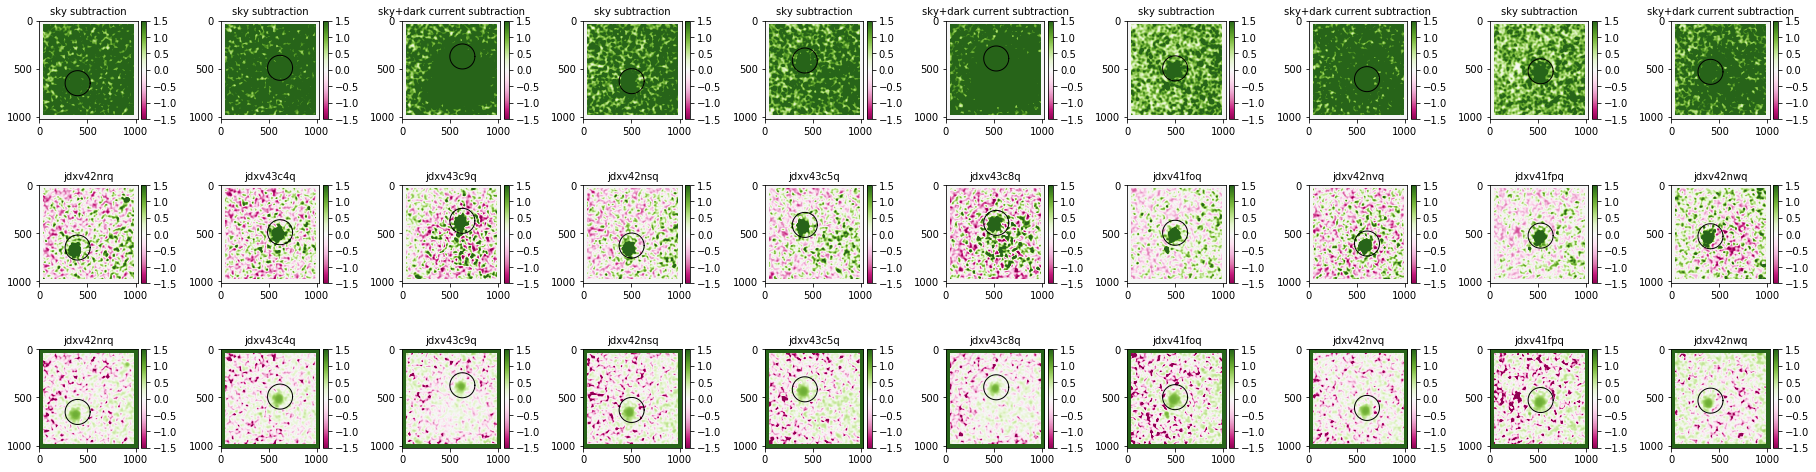

In [17]:
# make plots
fig, ax = plt.subplots(3,len(targets),figsize=(7*len(targets)/3+2, 7))
ax = ax.ravel()
for i in range(len(targets)):
    file = targets[i]
    flt = prepare(file)
    name = flt.name
    fd_file = prepare(file).path

    t = flt.expt
    image0 = fits.getdata(file)/t*1e5
    image1 = fits.getdata(fd_file)/t*1e5
    DQ = fits.getdata(file, 3)
    

    
    norm1=simple_norm(image0, 'linear',min_cut=-1.5, max_cut=1.5)
    
    
    if flt.temp < temp_cutoff:
        ax0_title = 'sky subtraction'
        r_out = flt.r_f+100
    else: 
        ax0_title = 'sky+dark current subtraction'
        r_out = flt.r_lim
        
        
    theta = np.linspace(0, 2*np.pi, 100)

    r = flt.r_f

    cx = r*np.cos(theta) + flt.w_x
    cy = r*np.sin(theta) + flt.w_y
    

    
    
    
    ####### plot #######
    
    
    
    ax[i].set_title(ax0_title, fontsize=10)
    kernel = g2(10)
    image0[DQ!=0] = 0
    image0 =  convolve(image0, kernel, boundary=None)
    image0[DQ!=0] = 0
    im = ax[i].imshow(image0, cmap='PiYG', norm=norm1)
    ax[i].plot(cx, cy, color='k', lw = 1)

    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="5%", pad=0.05)

    plt.colorbar(im, cax=cax)
    

     
    ax[i + len(targets)].set_title(name, fontsize=10)
    kernel = g2(10)
    image1[DQ!=0] = 0
    image1 =  convolve(image1, kernel, boundary=None)
    image1[DQ!=0] = 0
    im = ax[i + len(targets)].imshow(image1, cmap='PiYG', norm=norm1)
    ax[i + len(targets)].plot(cx, cy, color='k', lw = 1)
    divider = make_axes_locatable(ax[i + len(targets)])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    
    norm1=simple_norm(image1/image0, 'linear',min_cut=-1.5, max_cut=1.5)
    ax[i + 2*len(targets)].set_title(name, fontsize=10)

    im = ax[i + 2*len(targets)].imshow(image1/image0, cmap='PiYG', norm=norm1)
    ax[i + 2*len(targets)].plot(cx, cy, color='k', lw = 1)
    divider = make_axes_locatable(ax[i + 2*len(targets)])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    
    
    


    
    
plt.tight_layout()      
path = plot_dir+'old'+'.png'       
plt.show()  

fig.savefig(path, dpi=600)